# Tutorial on Active Inference with PyMDP

This set of 3 tutorial notebooks aims to be an accessible introduction to discrete-state-space active inference modelling with the PyMDP library. We assume no prerequisites other than a good grasp of python and some basic mathematical knowledge (specifically some familiarity with probability and linear algebra). We assume no prior knowledge of active inference. Hopefully, by the end of this series of notebooks, you will understand active inference well enough to understand the recent literature, as well as implement your own agents!

These tutorials will walk you through the specification, and construction of an active inference agent which can solve a simple navigation task in a gridworld environment. The goal here is to implement the agent 'from scratch'. Specifically, instead of just using magical library functions, we will show you an example of how these functions could be implemented which works for simple agents. The goal at the end of these tutorials is that you understand at a fairly detailed level how active inference works in discrete state spaces and how to apply it, as well as how you could implement a simple agent without using the PyMDP library. Once you understand what the PyMDP library aims to abstract, we will go through the structure and functionality offered by the library, and show how you can construct complex agents in a simple and straightforward way.

# What is Active Inference?

Fundamentally, the core contention of active inference is that the brain (and agents in general) can be thought of as fundamentally performing (Bayesian) inference about the world. Specifically, an agent performs two functions.


1.) **Perception**. An agent does not necessarily know the true state of the world, but instead must infer it from a limited set of observations.


2.) **Action**. Typically the agent can also perform the actions which change the state of the world. The agent can use these actions to drive the world towards a set of states that it desires. 

The theory of Active Inference argues that both of these processes can be represented and solved as Bayesian inference problems. 

# What is Bayesian Inference?

Bayesian inference provides a recipe for performing *optimal* inference. That is, if you have some set of Hypotheses $H$ and some set of data $D$. Then Bayesian inference allows you to compute the *best possible* update to your hypotheses given the data that you have. For instance, suppose you are a trader and you want to know whether some stock will go up tomorrow. And you have a set of information about that stock (for instance earnings reports, sales data, rumours a friend of a friend told you etc). Then Bayesian inference provides the *optimal way* to estimate the probability that the stock will go up. In this scenario, our "hypotheses" $H$ is that the stock will go up, or it will go down and our "data" $D$ is the various pieces of information we hold.

The fundamental equation in Bayesian inference is **Bayes Rule**. Which is 
$$
\begin{align}
p(H | D) = \frac{p(D | H)p(H)}{p(D)}
\end{align}
$$
Here $p(H)$ etc are *probability distributions*. All a probability distribution is is a function that assigns a probability value (between 0 and 1) to a specific outcome. A probability distribution then represents the probability of that outcome for every possible outcome. For instance, take p(H). This is the probability distribution over our *hypothesis space* which is whether the stock will go up or down i.e. $p(H) = [p(stock\_goes\_up), p(stock\_goes\_down)]$.

If we assume we have no idea whether the stock will go up or down, we can say that the probability in each case is 0.5 so that $p(H) = [0.5, 0.5]$. When there are a discrete set of possible outcomes. Probability distributions can be simply represented as vectors with one element for each outcome. The sum of all the elements of a probability distribution must equal 1 (since if you are considering *all possible events* then one of them *must* occur).



There are three fundamental quantities in Bayesian inference: the **posterior**, the **likelihood** and the **prior**. The posterior is ultimately the goal of inference, it is $p(H | D)$. What this represents is the probability of each hypothesis in the hypothesis space *given the data $D$*. I.e. it represents your best guesses at the truth of each hypothesis after optimally integrating the data. Next is the **prior** $p(H)$ which represents your idea about how likely each hypothesis is a-priori *before seeing the data*. Finally, there is the likelihood $p(D | H)$ which quantifies how likely each bit of data you see is, given each hypothesis. The likelihood distribution can also be thought of as a *model* for how the data relates to the hypotheses. 

The key insight of Bayes rule is simply that the posterior probability -- how likely the hypothesis is given the data -- is simply the likelihood times the prior -- i.e. how likely is the data given the hypothesis multiplied by how likely is the hypothesis. Effectively, hypotheses are more likely if they can predict the data well, but are also weighted by their a-priori probability. The marginal likelihood $p(D)$ is there effectively to just normalize the posterior (i.e. make sure it equals 1).

# Generative Models

In Active Inference we typically talk about *generative models* as a core component. But what are generative models? Technically a generative model is simply the product of a likelihood and a prior. This is also known as a *joint distribution* $p(H,D) = p(D | H)p(H)$. The generative model, then, is simply the numerator of Bayes rule, and if we normalize it we can compute posterior probabilities. It is called a generative model because it allows you to *generate* samples of the data. To do so, we follow the following steps:

1.) Sample a hypothesis $h_i$ from the prior -- i.e. $p(H)$

2.) Sample a datum from the likelihood distribution given that hypothesis i.e. sample $d_i$ from $p(D | H = h_i)$.

Another way to think about a generative model is that it is simply a model of how the data you have are generated. This is often a very helpful way to think about inference problems since it accords with our notion of causality -- i.e. i.e. there are unknown processes in the world which generate data. If we can imagine a process and then imagine the data generated by this process, then we have a generative model. Inference of the posterior, on the other hand, is more difficult because it goes in the *reverse* direction -- i.e. you have some set of observations and want to reconstruct the process that gave rise to them. Fundamentally, all of Bayesian statistics can be broken down into two steps:

1.) Given some data, make a mathematical model of the sort of process you think gave rise to the data (i.e. come up with a generative model). This model likely has a set of unknown parameters which you want to fit given the data.

2.) Given your generative model and the data, compute the posterior distribution over the unknown parameters using Bayes rule, or some approximation of Bayes rule.

3.) Be happy!

All the methods in Bayesian statistics essentially fall into two classes. Coming up with more expressive and powerful generative models and then figuring out algorithms to perform inference on them.

# Why is Bayesian Inference hard?

At this point, you may be wondering: Bayesian inference seems pretty easy. We known Bayes rule. We can invent generative models easily enough. Computing the posterior is just taking the generative model and dividing it by $p(D)$. Why all this fuss? Why do we need to make a whole academic field out of this anyway? Luckily this has a straightforward answer. Bayesian inference is hard for essentially just one reason: that computing $p(D)$, the normalizing constant, is hard.

Let's think about why. $p(D)$, which is known as the **marginal likelihood**, is fundamentally just the probability of the data. What does that mean? How is there just some free-floating probability of the data? Fundamentally there isn't. $p(D)$ is the probability of the data *averaged over all possible hypotheses*. We can write this as,
$$
\begin{align}
p(D) = \sum_h p(D | H)p(H)
\end{align}
$$

Effectively, $p(D)$ is the sum over all possible hypotheses of the probability of the data given that hypothesis, weighted by the prior probability of that hypothesis. This is challenging to compute in practice because you are often using really large (or indeed often infinite) hypothesis spaces. For instance, suppose your trader doesn't just want to know whether the stock will go up or down but *how much* it will go up or down. Now, with this simple change, you have an *infinite* amount of hypotheses: $p(H) = [p(stock\_goes\_up\_0.00001), p(stock\_goes\_up\_0.00002), p(stock\_goes\_up\_0.00003) ...]$. Then, if we want to compute the posterior in this case, we need to sum over every one of this infinite amount of hypotheses. You can see why this ends up being quite challenging in practice.

Because of this intrinsic difficulty, there are a large number of special case algorithms which can solve (or usually approximate) the Bayesian posterior in various cases, and a large amount of work in statistics goes into inventing new ones or improving existing methods. Active Inference agents use one special class of approximate Bayesian inference methods called *variational methods* or *variational inference*. This will be discussed in much more detail in notebook 2.

Beyond merely the difficulty of performing inference, another reason why Bayesian statistics is hard is that you often *don't know* the generative model. Or at least you are uncertain about some aspects of it. There is also a wide class of methods which let you perform inference and *learning* simultaneously, including for active inference, although they won't be covered in this tutorial.

# A Generative Model for an Agent

In Active Inference, we typically go a step beyond the simple cases of Bayesian inference described above, where we have a static set of hypotheses and some static data. We are instead interested in the case of an *agent* interacting with a *dynamic environment*. The key thing we need to add to the formalism to accomodate this is a notion of *time*. We consider an environment consisting of a set of *states* $[x_1, x_2, \dots x_t]$ evolving over time. Moreover, there is an agent which is in the environment over time. This agent receives a set of *observations* $[o_1, o_2 \dots o_t]$, which are a function of the state of the environment, and it can emit *actions* $[a_1, a_2 \dots a_t]$ which can change the state of the environment. The key step to get a handle on this situation mathematically is to define a *generative model* of it. 

To start, we must make some assumptions to simplify the problem. Specifically, we assume that the *state* of the environment $x_t$ only depends on the state at the previous timestep $x_{t-1}$ and the action emitted by the agent at the previous timestep $a_{t-1}$. Then, we assume that the observation $o_t$ at a given time-step is only a function of the environmental state at the current timestep $x_t$. Together, these assumptions are often called the **Markov Assumptions** and if the environment adheres to them it is often called a **Markov Decision Process**. 

The general computational "flow" of a Markov decision process can be thought of as following a sequence of steps.

1.) The state of the environment is $x_t$. 

2.) The environment state $x_t$ generates an observation $o_t$.

3.) The agent perceives $o_t$ and from it computes some kind of action $a_t$ which it executes in the environment.

4.) Given $x_t$ and $a_t$ the environment updates its own state to produce $x_{t+1}$

5.) Go back to step 1.

Now that we have this series of steps, we can try to define what it means mathematically. Specifically, we need to define two quantities. 

a.) We need to know how the state of the environment $x_t$ is reflected in the observation sent to the agent $o_t$. In Bayesian terms from the agent's perspective, the states of the environment are unknown and can be thought of as "hypotheses", while the observations it receives are "data". This means we can describe this function as the **likelihood distribution** $p(D | H)$ or, in our new notation $p(o_t | x_t)$. 

b.) We need to know how the environment updates itself to form its new state given the old one and the action. This can be thought of (from the perspective of the agent who does not observe it) as the **prior** since it can be thought of as the default expectation the agent can have about the state of the environment prior to receiving any observations. It can be written as $p(x_t | x_{t-1}, a_{t-1})$. This distribution is also known as the **transition distribution** since it specifies how the environment transitions from one state to another.

These two distributions $p(o_t | x_t)$ and $p(x_t | x_{t-1}, a_{t-1})$ are all that is needed to specify the evolution of the environment. At this point, it is necessary to make a distinction between the *actual* evolution of the environment -- known as the **generative process** -- and the *agent's model* of the evolution of the environment, which is known as the **generative model**. These are not necessarily the same, although in some sense the goal of the agent is to figure out a generative model as close to the true generative process as possible. In this example, we will consider that the agent knows the true model, so the generative model and the generative process are the same, although this is not always the case.

To make this concrete, all that is necessary to do is to specify precisely what the **likelihood** and **transition** distributions actually are.

In the case of discrete state spaces, where it is possible to explicitly enumerate all states, a very generic way of representing these distributions is as *matrices*. Specifically, we can represent the likelihood distribution as a matrix denoted $\textbf{A}$, which is of shape $dimension\_of\_observation \times dimension\_of\_state$. The element $A_{i,j}$ of $\textbf{A}$ represents the probability that observation $i$ is generated by state $j$.

Secondly, we can represent the transition distribution by a matrix $\textbf{B}$ of shape $state\_dim \times state\_dim \times action\_dim$ where element $\textbf{B}_{i,j,k}$ represents the probability of the environment moving to state $i$ given that it was previously in state $j$ and that action $k$ was taken.

In the rest of this notebook, we will explicitly write down the generative process / generative model for a simple grid-world environment in code, to get a better handle on how the environment and the agent's model is specified. In the next notebook, we will turn to inference and action selection and discuss how active inference solves these two tricky problems.



In [9]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Constructing a Generative Model 

For the rest of this notebook, we will construct a simple generative model for an active inference agent navigating a 3x3 grid world environment. The agent can perform one of 5 actions at each time step: `LEFT, RIGHT, UP, DOWN, STAY`. The goal of the agent is to navigate to its preferred position. 

We will create matrices for both the environment as well as the agent itself. As we go up levels of abstraction, these environment and generative model matrices will be imported from classes - but this notebook is the lowest level representation of construction, to show how everything is built from the ground up.  


## Understanding the state space

The first thing to note is that we are in a 3x3 grid world which means we have 9 states in total. We can define the following mapping to better understand the space:

In [10]:
state_mapping = {0: (0,0), 1: (1,0), 2: (2,0), 3: (0,1), 4: (1,1), 5:(2,1), 6: (0,2), 7:(1,2), 8:(2,2)}

And the following heatmap just represents how the coordinates map to the real grid space

<AxesSubplot:>

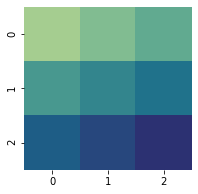

In [11]:
grid = np.zeros((3,3))
c = 1
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        grid[i,j] += c
        c += 1
fig = plt.figure(figsize = (3,3))
sns.heatmap(grid, cbar = False, cmap = 'crest')

## Likelihood Matrix: A

The likelihood matrix represents $P(o_t | s_t)$ , the probability of an observation given a state. In a grid world environment, the likelihood matrix of the agent is identical to that of the environment. It is simply the identity matrix over all states (in this case 9 states, for a 3x3 grid world) which represents the fact that the agent has probability 1 of observing that it is occupying any state x, given that it is in state x. This just means that the agent has full transparency over its own location in the grid. 

In [14]:
A = np.eye(9)

In [15]:
A

array([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.]])

We can also plot the likelihood matrix as follows:

In [16]:
labels = [state_mapping[i] for i in range(A.shape[1])]
def plot_likelihood(A):
    fig = plt.figure(figsize = (6,6))
    ax = sns.heatmap(A, xticklabels = labels, yticklabels = labels, cbar = False)
    plt.title("Likelihood distribution (A)")
    plt.show()


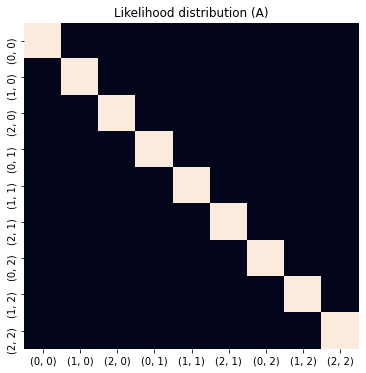

In [17]:
plot_likelihood(A)

## Transition matrix: B

The transition matrix determines how the agent can move around the gridworld given each of the 5 availabel actions (UP, DOWN, LEFT, RIGHT, STAY). 
So the transition matrix will be a 9x9x5 matrix, where each entry corresponds to a starting state, an end state, and the action that defines that specific transition. 

To construct this matrix, we have to understand that when the agent is at the edges of the grid, it cannot move outward, so trying to move right at the right wall will cause the agent to stay still. 

We will start by constructing a dictionary which we call P, which maps each state to its next state given an action

In [18]:
state_mapping

{0: (0, 0),
 1: (1, 0),
 2: (2, 0),
 3: (0, 1),
 4: (1, 1),
 5: (2, 1),
 6: (0, 2),
 7: (1, 2),
 8: (2, 2)}

In [19]:
P = {}
dim = 3
actions = {'UP':0, 'RIGHT':1, 'DOWN':2, 'LEFT':3, 'STAY':4}
for s in state_mapping.keys():
    P[s] = {a : [] for a in range(len(actions))}
    x, y = state_mapping[s][0], state_mapping[s][1]

    P[s][actions['UP']] = s if y == 0 else s - dim
    P[s][actions["RIGHT"]] = s if x == (dim -1) else s+1
    P[s][actions['DOWN']] = s if y == (dim -1) else s + dim 
    P[s][actions['LEFT']] = s if x == 0 else s -1 
    P[s][actions['STAY']] = s 

In [20]:
P

{0: {0: 0, 1: 1, 2: 3, 3: 0, 4: 0},
 1: {0: 1, 1: 2, 2: 4, 3: 0, 4: 1},
 2: {0: 2, 1: 2, 2: 5, 3: 1, 4: 2},
 3: {0: 0, 1: 4, 2: 6, 3: 3, 4: 3},
 4: {0: 1, 1: 5, 2: 7, 3: 3, 4: 4},
 5: {0: 2, 1: 5, 2: 8, 3: 4, 4: 5},
 6: {0: 3, 1: 7, 2: 6, 3: 6, 4: 6},
 7: {0: 4, 1: 8, 2: 7, 3: 6, 4: 7},
 8: {0: 5, 1: 8, 2: 8, 3: 7, 4: 8}}

From here, we can easily construct the transition matrix

In [21]:
num_states = 9
B = np.zeros([num_states, num_states, len(actions)])
for s in range(num_states):
    for a in range(len(actions)):
        ns = int(P[s][a])
        B[ns, s, a] = 1
        

B is a very large matrix, we can see its shape below, which is as expected:

In [22]:
B.shape

(9, 9, 5)

We can also visualize B on the plots below. The x axis is the starting state, and the y axis is the ending state, and each plot corresponds to an action given by the title.

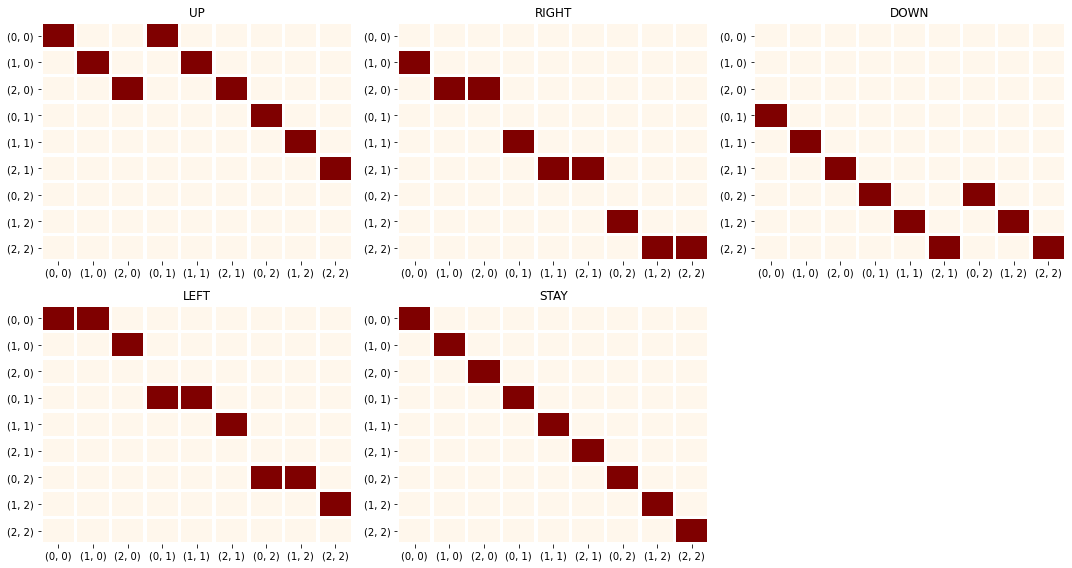

In [23]:
fig, axes = plt.subplots(2,3, figsize = (15,8))
a = list(actions.keys())
count = 0
for i in range(dim-1):
    for j in range(dim):
        if count >= 5:
            break 
        g = sns.heatmap(B[:,:,count], cmap = "OrRd", linewidth = 2.5, cbar = False, ax = axes[i,j], xticklabels=labels, yticklabels=labels)
        g.set_title(a[count])
        count +=1 
fig.delaxes(axes.flatten()[5])
plt.tight_layout()
plt.show()
    

Now our generative model and environment are set up, and we can move on to Notebook 2, where we go through the core mechanics of how to perform inference and planning on this environment with this generative model.